### Imports, config, logging

In [8]:
# Cell 1 — imports & config
import os, sys, json, math, shutil, logging, random
from glob import glob
from collections import Counter

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

import matplotlib.pyplot as plt

# ---------- logging
logging.basicConfig(level=logging.INFO, format='[%(levelname)s] %(asctime)s - %(message)s')
log = logging.getLogger("rice-pipeline")

# ---------- reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

# ---------- GPU memory growth (safe)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for g in gpus: tf.config.experimental.set_memory_growth(g, True)
        log.info(f"Using GPU(s): {[d.name for d in gpus]}")
    except Exception as e:
        log.warning(f"GPU config issue: {e}")
else:
    log.info("No GPU detected; training will use CPU.")

# ---------- paths & hyperparams
RAW_DATA_DIR = "/Users/soumyajitbera/Documents/GitHub/data/Rice_augmented"     # your current dataset
PROC_DATA_DIR = "data/Rice_processed"     # where preprocessed images will be written (optional)
USE_PROCESSED = False                     # set True after running Cell 2 once
DATA_DIR = PROC_DATA_DIR if USE_PROCESSED else RAW_DATA_DIR

OUT_DIR = "outputs_rice"
os.makedirs(OUT_DIR, exist_ok=True)
MODEL_PATH = os.path.join(OUT_DIR, "rice_cnn_best.keras")   # Keras v3 native format
CLASS_MAP_JSON = os.path.join(OUT_DIR, "class_indices.json")
HISTORY_CSV = os.path.join(OUT_DIR, "history.csv")
CONF_MAT_PNG = os.path.join(OUT_DIR, "confusion_matrix.png")
REPORT_TXT = os.path.join(OUT_DIR, "classification_report.txt")

IMG_SIZE = (224, 224)   # good for a compact scratch CNN
BATCH_SIZE = 32
EPOCHS = 40
VAL_SPLIT = 0.18
TEST_SPLIT = 0.12       # overall ≈ 70/18/12


[INFO] 2025-09-27 11:42:11,039 - No GPU detected; training will use CPU.


## Image preprocessing to create a “cleaner” dataset

In [9]:
# Cell 2 — optional preprocessing using OpenCV (run once to build data/Rice_processed)
import cv2

def leaf_crop_and_fix(img_bgr, pad=8):
    """Quick leaf crop via HSV green mask + CLAHE on L channel."""
    h, w = img_bgr.shape[:2]
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, (25, 20, 20), (95, 255, 255))     # broad green
    kernel = np.ones((5,5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, 1)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, 2)

    cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    crop = img_bgr
    if cnts:
        c = max(cnts, key=cv2.contourArea)
        x,y,wc,hc = cv2.boundingRect(c)
        x0 = max(0, x-pad); y0 = max(0, y-pad)
        x1 = min(w, x+wc+pad); y1 = min(h, y+hc+pad)
        crop = img_bgr[y0:y1, x0:x1]

    lab = cv2.cvtColor(crop, cv2.COLOR_BGR2LAB)
    L,A,B = cv2.split(lab)
    L2 = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8)).apply(L)
    out = cv2.cvtColor(cv2.merge([L2,A,B]), cv2.COLOR_LAB2BGR)
    return out

def build_processed_dataset(src_root, dst_root):
    if os.path.exists(dst_root):
        log.info(f"Removing existing processed dir: {dst_root}")
        shutil.rmtree(dst_root)
    os.makedirs(dst_root, exist_ok=True)

    classes = sorted([d for d in os.listdir(src_root) if os.path.isdir(os.path.join(src_root,d))])
    total, ok = 0, 0
    for cls in classes:
        sdir = os.path.join(src_root, cls)
        ddir = os.path.join(dst_root, cls); os.makedirs(ddir, exist_ok=True)
        for p in glob(os.path.join(sdir, "*")):
            if not os.path.isfile(p): continue
            total += 1
            img = cv2.imread(p)
            if img is None: 
                log.warning(f"Unreadable: {p}"); continue
            fixed = leaf_crop_and_fix(img)
            cv2.imwrite(os.path.join(ddir, os.path.basename(p)), fixed)
            ok += 1
    log.info(f"Processed {ok}/{total} images -> {dst_root}")

# Run once if you want the processed dataset, then set USE_PROCESSED=True in Cell 1.
# build_processed_dataset(RAW_DATA_DIR, PROC_DATA_DIR)


## Scan dataset, stratified train/val/test split + class histogram

In [10]:
# Cell 3 — scan & split
def scan_images(root):
    class_names = sorted([d for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))])
    files, labels = [], []
    for idx, cls in enumerate(class_names):
        for p in glob(os.path.join(root, cls, "*")):
            if os.path.isfile(p):
                files.append(p)
                labels.append(idx)
    return class_names, np.array(files), np.array(labels)

class_names, all_files, all_labels = scan_images(DATA_DIR)
log.info(f"Classes: {class_names}; total images: {len(all_files)}")

X_trainval, X_test, y_trainval, y_test = train_test_split(
    all_files, all_labels, test_size=TEST_SPLIT, random_state=SEED, stratify=all_labels
)
val_size_adj = VAL_SPLIT / (1.0 - TEST_SPLIT)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=val_size_adj, random_state=SEED, stratify=y_trainval
)

with open(CLASS_MAP_JSON, "w") as f:
    json.dump({name: i for i, name in enumerate(class_names)}, f, indent=2)
log.info(f"Saved class map -> {CLASS_MAP_JSON}")
log.info(f"Split sizes -> train: {len(X_train)}, val: {len(X_val)}, test: {len(X_test)}")


[INFO] 2025-09-27 11:44:34,129 - Classes: ['Bacterialblight', 'Brownspot', 'Leafsmut']; total images: 4562
[INFO] 2025-09-27 11:44:34,134 - Saved class map -> outputs_rice/class_indices.json
[INFO] 2025-09-27 11:44:34,134 - Split sizes -> train: 3192, val: 822, test: 548


## tf.data pipeline with augmentation

In [11]:
# Cell 4 — tf.data with built-in augmentations (no Addons)
AUTOTUNE = tf.data.AUTOTUNE

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.05),          # ~±8°
    layers.RandomZoom(0.10),
    layers.RandomContrast(0.20),
], name="aug")

def decode_img(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.convert_image_dtype(img, tf.float32)  # [0,1]
    img = tf.image.resize(img, IMG_SIZE, antialias=True)
    return img

def make_ds(paths, labels, training=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    def _load(p, y):
        img = decode_img(p)
        if training:
            img = data_augmentation(img)
        y1 = tf.one_hot(y, depth=len(class_names))
        return img, y1
    ds = ds.map(_load, num_parallel_calls=AUTOTUNE)
    if training:
        ds = ds.shuffle(2048, seed=SEED, reshuffle_each_iteration=True)
    return ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

train_ds = make_ds(X_train, y_train, training=True)
val_ds   = make_ds(X_val,   y_val,   training=False)
test_ds  = make_ds(X_test,  y_test,  training=False)


## CNN from scratch (lightweight, tuned for leaf textures)

In [12]:
# Cell 5 — custom CNN model
def conv_block(x, filters, k=3, pool=True):
    x = layers.Conv2D(filters, k, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    if pool: x = layers.MaxPooling2D()(x)
    return x

def build_cnn(input_shape=(224,224,3), num_classes=3, dropout=0.5):
    inputs = layers.Input(shape=input_shape)
    x = conv_block(inputs, 32)         # 224->112
    x = conv_block(x, 64)              # 112->56
    x = conv_block(x, 128)             # 56->28
    x = conv_block(x, 192)             # 28->14
    x = conv_block(x, 256, pool=False) # keep detail at 14x14
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs, name="RiceCNN")

model = build_cnn(input_shape=(*IMG_SIZE,3), num_classes=len(class_names), dropout=0.5)
model.summary()

loss = keras.losses.CategoricalCrossentropy(label_smoothing=0.05)
opt  = keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=opt, loss=loss, metrics=["accuracy"])


Model: "RiceCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 192)    │       221,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 192)    │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 28, 28, 192)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 192)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 256)    │       442,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 14, 14, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             

 Total params: 792,547 (3.02 MB)

 Trainable params: 791,203 (3.02 MB)

 Non-trainable params: 1,344 (5.25 KB)

### Class weights, callbacks, training with logs, save best

In [13]:
# Cell 6 — training with logs & best checkpoint
classes_unique = np.unique(y_train)
weights = compute_class_weight(class_weight="balanced", classes=classes_unique, y=y_train)
class_weight = dict(zip(classes_unique.tolist(), weights.tolist()))
log.info(f"class_weight: {class_weight}")

csv_logger = keras.callbacks.CSVLogger(HISTORY_CSV, append=False)
ckpt   = keras.callbacks.ModelCheckpoint(MODEL_PATH, monitor="val_accuracy",
                                         save_best_only=True, verbose=1)
early  = keras.callbacks.EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True)
plateau= keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=3, verbose=1)

log.info("Starting training...")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weight,
    callbacks=[csv_logger, ckpt, early, plateau],
    verbose=1
)
log.info(f"Training done. Best model stored at -> {MODEL_PATH}")


[INFO] 2025-09-27 11:47:38,468 - class_weight: {0: 1.0672016048144433, 1: 0.9292576419213974, 2: 1.0133333333333334}
[INFO] 2025-09-27 11:47:38,469 - Starting training...


Epoch 1/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 943ms/step - accuracy: 0.6558 - loss: 0.9105
Epoch 1: val_accuracy improved from None to 0.36618, saving model to outputs_rice/rice_cnn_best.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 105s 1000ms/step - accuracy: 0.7215 - loss: 0.7702 - val_accuracy: 0.3662 - val_loss: 1.4737 - learning_rate: 0.0010
Epoch 2/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 971ms/step - accuracy: 0.8013 - loss: 0.6029
Epoch 2: val_accuracy improved from 0.36618 to 0.58394, saving model to outputs_rice/rice_cnn_best.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.8083 - loss: 0.5821 - val_accuracy: 0.5839 - val_loss: 0.9443 - learning_rate: 0.0010
Epoch 3/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8379 - loss: 0.5412
Epoch 3: val_accuracy did not improve from 0.58394
100/100 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.8468 - loss: 0.5323 - val_accuracy: 0.5706 - val_loss: 0.9356 - learning_rate: 0.0010
Epoch 4/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step 

2025-09-27 12:28:57.864673: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1040 of 2048
2025-09-27 12:28:59.985448: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 955ms/step - accuracy: 0.9227 - loss: 0.3682
Epoch 12: val_accuracy improved from 0.92092 to 0.96350, saving model to outputs_rice/rice_cnn_best.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 682s 1s/step - accuracy: 0.9283 - loss: 0.3574 - val_accuracy: 0.9635 - val_loss: 0.2889 - learning_rate: 0.0010
Epoch 13/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 961ms/step - accuracy: 0.9305 - loss: 0.3512
Epoch 13: val_accuracy did not improve from 0.96350
100/100 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - accuracy: 0.9358 - loss: 0.3481 - val_accuracy: 0.7263 - val_loss: 0.8522 - learning_rate: 0.0010
Epoch 14/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 949ms/step - accuracy: 0.9283 - loss: 0.3542
Epoch 14: val_accuracy did not improve from 0.96350
100/100 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0.9283 - loss: 0.3601 - val_accuracy: 0.8917 - val_loss: 0.4201 - learning_rate: 0.0010
Epoch 15/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 967ms/step - accuracy: 0.9434 - loss: 0.3314
Epoch 15: val_accura

[INFO] 2025-09-27 13:53:25,104 - Training done. Best model stored at -> outputs_rice/rice_cnn_best.keras


## Curves (accuracy & loss) and histogram of prediction confidences on val set

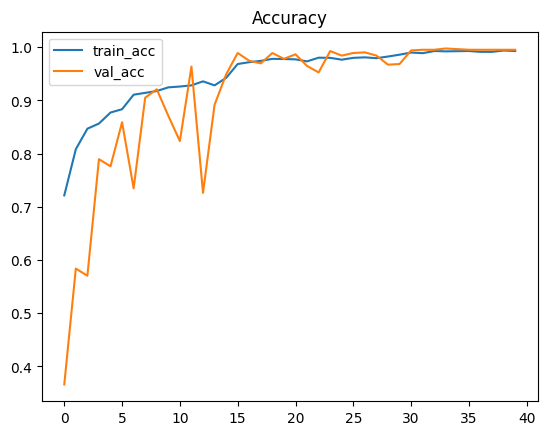

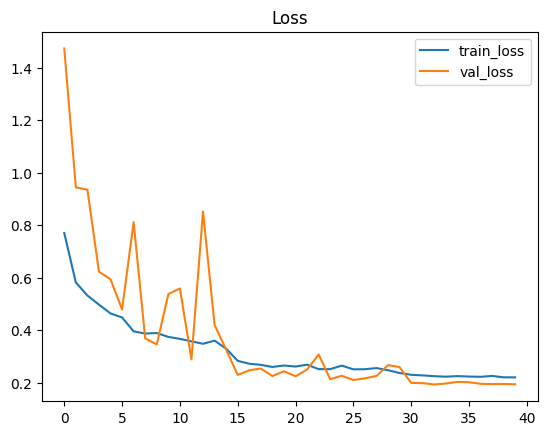

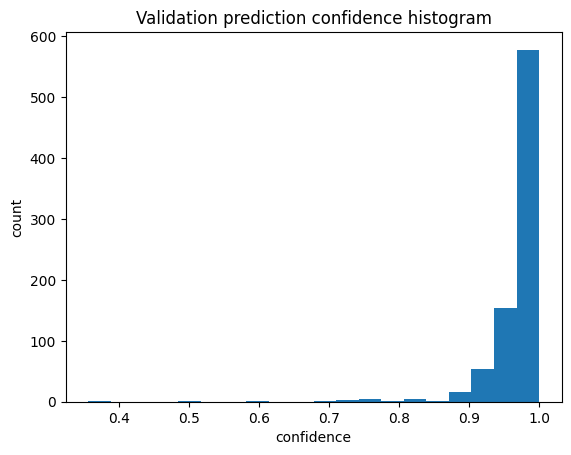

In [14]:
# Cell 7 — curves & confidence histogram
def plot_curves(h):
    plt.figure(); plt.plot(h.history["accuracy"], label="train_acc")
    plt.plot(h.history["val_accuracy"], label="val_acc"); plt.legend(); plt.title("Accuracy"); plt.show()

    plt.figure(); plt.plot(h.history["loss"], label="train_loss")
    plt.plot(h.history["val_loss"], label="val_loss"); plt.legend(); plt.title("Loss"); plt.show()

plot_curves(history)

# confidence histogram on validation
y_val_probs = model.predict(val_ds, verbose=0)
conf = np.max(y_val_probs, axis=1)
plt.figure(); plt.hist(conf, bins=20); plt.title("Validation prediction confidence histogram")
plt.xlabel("confidence"); plt.ylabel("count"); plt.show()


## Load best model, evaluate on test set, confusion matrix & report

[INFO] 2025-09-27 14:21:33,956 - TEST — loss: 0.1923, acc: 0.9982
2025-09-27 14:21:37.798943: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


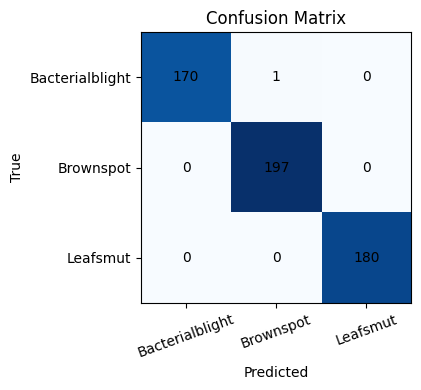

[INFO] 2025-09-27 14:21:37,853 - Saved confusion matrix -> outputs_rice/confusion_matrix.png
[INFO] 2025-09-27 14:21:37,858 - Saved report -> outputs_rice/classification_report.txt


                 precision    recall  f1-score   support

Bacterialblight     1.0000    0.9942    0.9971       171
      Brownspot     0.9949    1.0000    0.9975       197
       Leafsmut     1.0000    1.0000    1.0000       180

       accuracy                         0.9982       548
      macro avg     0.9983    0.9981    0.9982       548
   weighted avg     0.9982    0.9982    0.9982       548



In [15]:
# Cell 8 — test evaluation + confusion matrix/report
best_model = keras.models.load_model(MODEL_PATH)
test_loss, test_acc = best_model.evaluate(test_ds, verbose=0)
log.info(f"TEST — loss: {test_loss:.4f}, acc: {test_acc:.4f}")

y_true, y_pred = [], []
for imgs, labs in test_ds:
    probs = best_model.predict(imgs, verbose=0)
    y_pred.extend(np.argmax(probs, axis=1))
    y_true.extend(np.argmax(labs.numpy(), axis=1))
y_true, y_pred = np.array(y_true), np.array(y_pred)

cm = confusion_matrix(y_true, y_pred, labels=list(range(len(class_names))))
plt.figure(figsize=(5,4))
plt.imshow(cm, cmap="Blues"); plt.title("Confusion Matrix")
plt.xticks(range(len(class_names)), class_names, rotation=20)
plt.yticks(range(len(class_names)), class_names)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j,i,cm[i,j],ha="center",va="center")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.tight_layout()
plt.savefig(CONF_MAT_PNG); plt.show()
log.info(f"Saved confusion matrix -> {CONF_MAT_PNG}")

report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
with open(REPORT_TXT, "w") as f: f.write(report)
print(report); log.info(f"Saved report -> {REPORT_TXT}")


## Quick single-image & folder prediction helpers (for manual checks)

In [17]:
def load_and_prep(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, IMG_SIZE, antialias=True)
    return tf.expand_dims(img, 0)

def predict_image(path):
    img = load_and_prep(path)
    probs = best_model.predict(img, verbose=0)[0]
    idx = int(np.argmax(probs))
    return class_names[idx], float(probs[idx])

# example:
# pred, conf = predict_image("DSC_0293.JPG"); print(pred, conf)

def evaluate_folder(dir_path):
    paths = [p for p in glob(os.path.join(dir_path, "*")) if os.path.isfile(p)]
    rows = []
    for p in paths:
        try:
            label, conf = predict_image(p)
            rows.append((os.path.basename(p), label, conf))
        except Exception as e:
            log.error(f"Failed {p}: {e}")
    return rows

# ex:
# rows = evaluate_folder("some_test_folder")
# for r in rows[:10]: print(r)
